In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import umap
from sklearn.decomposition import PCA
from tqdm import tqdm
from numpy import linalg as LA
import pickle

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()[:, pred_start:pred_end]
pro_s1d2 = pro_s1d2.X.toarray()[:, pred_start:pred_end]
pro_s1d3 = pro_s1d3.X.toarray()[:, pred_start:pred_end]
pro_s2d1 = pro_s2d1.X.toarray()[:, pred_start:pred_end]
pro_s2d4 = pro_s2d4.X.toarray()[:, pred_start:pred_end]
pro_s2d5 = pro_s2d5.X.toarray()[:, pred_start:pred_end]

pro_s3d1 = pro_s3d1.X.toarray()[:, pred_start:pred_end]
pro_s3d6 = pro_s3d6.X.toarray()[:, pred_start:pred_end]
pro_s3d7 = pro_s3d7.X.toarray()[:, pred_start:pred_end]

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8.X.toarray()[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9.X.toarray()[:, pred_start:pred_end]

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 1)


In [17]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [18]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [19]:
# train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
# train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

train_input = [RNA_s1d1]
train_output = [pro_s1d1]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d9]
test_output = [pro_s4d9]

In [20]:
train_input = train_input
train_output = train_output

In [21]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [22]:
RNA_s1d1 = torch.from_numpy(RNA_s1d1)
RNA_s1d2 = torch.from_numpy(RNA_s1d2)
RNA_s1d3 = torch.from_numpy(RNA_s1d3)
RNA_s2d1 = torch.from_numpy(RNA_s2d1)
RNA_s2d4 = torch.from_numpy(RNA_s2d4)
RNA_s2d5 = torch.from_numpy(RNA_s2d5)
RNA_s3d1 = torch.from_numpy(RNA_s3d1)
RNA_s3d6 = torch.from_numpy(RNA_s3d6)
RNA_s3d7 = torch.from_numpy(RNA_s3d7)
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

In [23]:
pro_s1d1 = torch.from_numpy(pro_s1d1)
pro_s1d2 = torch.from_numpy(pro_s1d2)
pro_s1d3 = torch.from_numpy(pro_s1d3)
pro_s2d1 = torch.from_numpy(pro_s2d1)
pro_s2d4 = torch.from_numpy(pro_s2d4)
pro_s2d5 = torch.from_numpy(pro_s2d5)
pro_s3d1 = torch.from_numpy(pro_s3d1)
pro_s3d6 = torch.from_numpy(pro_s3d6)
pro_s3d7 = torch.from_numpy(pro_s3d7)
pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [24]:
train_input = torch.from_numpy(train_input)
val_input = torch.from_numpy(val_input)
test_input = torch.from_numpy(test_input)

train_output = torch.from_numpy(train_output)
val_output = torch.from_numpy(val_output)
test_output = torch.from_numpy(test_output)

In [25]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

print(train_output.shape)
print(val_output.shape)
print(test_output.shape)

torch.Size([4721, 13953])
torch.Size([28921, 13953])
torch.Size([459, 13953])
torch.Size([4721, 1])
torch.Size([28921, 1])
torch.Size([459, 1])


In [26]:
def top_samples(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return [ele[1] for ele in temp_list[:num]]

In [27]:
nn_num = 1

In [28]:
input_near_ind_list = []
output_near_ind_list = []

for i in tqdm(range(test_input.shape[0])):
    near_neig_ind = top_samples(test_input[i], train_input, nn_num)
    input_near_ind_list.append(train_input[near_neig_ind])
    output_near_ind_list.append(train_output[near_neig_ind])
    
input_near = np.concatenate(input_near_ind_list, axis= 0)
output_near = np.concatenate(output_near_ind_list, axis= 0)

100%|██████████| 459/459 [00:47<00:00,  9.72it/s]


In [29]:
def top_samples_distances(source, target, num):
    distances = LA.norm(source-target, axis=1)
    temp_list = []
    for i in range(len(distances)):
        temp_list.append([distances[i], i])
    temp_list.sort()
    return sum([ele[0] for ele in temp_list[:num]])

In [30]:
train_batches = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5, RNA_s3d1, RNA_s3d6, RNA_s3d7, RNA_s4d1, RNA_s4d8, RNA_s4d9]
train_batches_names = ['RNA_s1d1', 'RNA_s1d2', 'RNA_s1d3', 'RNA_s2d1', 'RNA_s2d4', 'RNA_s2d5', 'RNA_s3d1', 'RNA_s3d6', 'RNA_s3d7', 'RNA_s4d1', 'RNA_s4d8', 'RNA_s4d9']

for j in range(len(train_batches)):
    dis_sum = 0
    for i in range(RNA_s4d9.shape[0]):
        near_dis_sum = top_samples_distances(RNA_s4d9[i], train_batches[j], nn_num)
        dis_sum = dis_sum + near_dis_sum
    print('batch:', train_batches_names[j], 'distance sum:', dis_sum)

batch: RNA_s1d1 distance sum: 19550.59052658081
batch: RNA_s1d2 distance sum: 19818.059366226196
batch: RNA_s1d3 distance sum: 19234.677911758423
batch: RNA_s2d1 distance sum: 19669.051919937134
batch: RNA_s2d4 distance sum: 19908.85652923584
batch: RNA_s2d5 distance sum: 19729.082748413086
batch: RNA_s3d1 distance sum: 21469.199670791626
batch: RNA_s3d6 distance sum: 19756.92838859558
batch: RNA_s3d7 distance sum: 19844.717975616455
batch: RNA_s4d1 distance sum: 20746.655853271484
batch: RNA_s4d8 distance sum: 21443.42197036743
batch: RNA_s4d9 distance sum: 0.0


In [31]:
# with open(r"input_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(input_near, output_file)
    
# with open(r"output_near_eucli.pickle", "wb") as output_file:
#     pickle.dump(output_near, output_file)

In [32]:
# with open(r"input_near_eucli.pickle", "rb") as input_file:
#     input_near = pickle.load(input_file)
    
# with open(r"output_near_eucli.pickle", "rb") as input_file:
#     output_near = pickle.load(input_file)

In [33]:
RNA_s1d1 = RNA_s1d1.float()
RNA_s1d2 = RNA_s1d2.float()
RNA_s1d3 = RNA_s1d3.float()
RNA_s2d1 = RNA_s2d1.float()
RNA_s2d4 = RNA_s2d4.float()
RNA_s2d5 = RNA_s2d5.float()
RNA_s3d1 = RNA_s3d1.float()
RNA_s3d6 = RNA_s3d6.float()
RNA_s3d7 = RNA_s3d7.float()
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s1d1 = pro_s1d1.float()
pro_s1d2 = pro_s1d2.float()
pro_s1d3 = pro_s1d3.float()
pro_s2d1 = pro_s2d1.float()
pro_s2d4 = pro_s2d4.float()
pro_s2d5 = pro_s2d5.float()
pro_s3d1 = pro_s3d1.float()
pro_s3d6 = pro_s3d6.float()
pro_s3d7 = pro_s3d7.float()
pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [34]:
train_input = train_input.float()
val_input = val_input.float()
test_input = test_input.float()

train_output = train_output.float()
val_output = val_output.float()
test_output = test_output.float()

In [35]:
# input_near = input_near.float()
# output_near = output_near.float()

In [36]:
RNA_s1d1 = RNA_s1d1.to(device)
RNA_s1d2 = RNA_s1d2.to(device)
RNA_s1d3 = RNA_s1d3.to(device)
RNA_s2d1 = RNA_s2d1.to(device)
RNA_s2d4 = RNA_s2d4.to(device)
RNA_s2d5 = RNA_s2d5.to(device)
RNA_s3d1 = RNA_s3d1.to(device)
RNA_s3d6 = RNA_s3d6.to(device)
RNA_s3d7 = RNA_s3d7.to(device)
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s1d1 = pro_s1d1.to(device)
pro_s1d2 = pro_s1d2.to(device)
pro_s1d3 = pro_s1d3.to(device)
pro_s2d1 = pro_s2d1.to(device)
pro_s2d4 = pro_s2d4.to(device)
pro_s2d5 = pro_s2d5.to(device)
pro_s3d1 = pro_s3d1.to(device)
pro_s3d6 = pro_s3d6.to(device)
pro_s3d7 = pro_s3d7.to(device)
pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [37]:
train_input = train_input.to(device)
val_input = val_input.to(device)
test_input = test_input.to(device)

train_output = train_output.to(device)
val_output = val_output.to(device)
test_output = test_output.to(device)

In [38]:
# input_near = torch.from_numpy(input_near)
# output_near = torch.from_numpy(output_near)

In [39]:
input_near = torch.from_numpy(input_near)
output_near = torch.from_numpy(output_near)

input_near = input_near.to(device)
output_near = output_near.to(device)

In [40]:
input_feature = RNA_s1d1.shape[1]

In [41]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, 1)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [42]:
PATH = 'No_norm_model_RNA_pro'

In [43]:
def fit(num_epochs, model, loss_fn, RNA, pro):
    train_ds = TensorDataset(RNA, pro)
    train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            near_pred = model(input_near)
            near_loss = loss_fn(near_pred, output_near)
            near_loss = torch.sqrt(near_loss)
            near_loss = near_loss.cpu().detach().numpy()
            
            s1d1_pred = model(RNA_s1d1)
            s1d1_loss = loss_fn(s1d1_pred, pro_s1d1)
            s1d1_loss = torch.sqrt(s1d1_loss)
            s1d1_loss = s1d1_loss.cpu().detach().numpy()
            
            s1d2_pred = model(RNA_s1d2)
            s1d2_loss = loss_fn(s1d2_pred, pro_s1d2)
            s1d2_loss = torch.sqrt(s1d2_loss)
            s1d2_loss = s1d2_loss.cpu().detach().numpy()
            
            s1d3_pred = model(RNA_s1d3)
            s1d3_loss = loss_fn(s1d3_pred, pro_s1d3)
            s1d3_loss = torch.sqrt(s1d3_loss)
            s1d3_loss = s1d3_loss.cpu().detach().numpy()
            
            s2d1_pred = model(RNA_s2d1)
            s2d1_loss = loss_fn(s2d1_pred, pro_s2d1)
            s2d1_loss = torch.sqrt(s2d1_loss)
            s2d1_loss = s2d1_loss.cpu().detach().numpy()
            
            s2d4_pred = model(RNA_s2d4)
            s2d4_loss = loss_fn(s2d4_pred, pro_s2d4)
            s2d4_loss = torch.sqrt(s2d4_loss)
            s2d4_loss = s2d4_loss.cpu().detach().numpy()
            
            s2d5_pred = model(RNA_s2d5)
            s2d5_loss = loss_fn(s2d5_pred, pro_s2d5)
            s2d5_loss = torch.sqrt(s2d5_loss)
            s2d5_loss = s2d5_loss.cpu().detach().numpy()
            
            s3d1_pred = model(RNA_s3d1)
            s3d1_loss = loss_fn(s3d1_pred, pro_s3d1)
            s3d1_loss = torch.sqrt(s3d1_loss)
            s3d1_loss = s3d1_loss.cpu().detach().numpy()
            
            s3d6_pred = model(RNA_s3d6)
            s3d6_loss = loss_fn(s3d6_pred, pro_s3d6)
            s3d6_loss = torch.sqrt(s3d6_loss)
            s3d6_loss = s3d6_loss.cpu().detach().numpy()
            
            s3d7_pred = model(RNA_s3d7)
            s3d7_loss = loss_fn(s3d7_pred, pro_s3d7)
            s3d7_loss = torch.sqrt(s3d7_loss)
            s3d7_loss = s3d7_loss.cpu().detach().numpy()

            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            print('Epoch ', epoch, 'near loss:', near_loss, 's1d1: ', s1d1_loss, 's1d2: ', s1d2_loss, 's1d3: ', s1d3_loss, 's2d1:', s2d1_loss, 's2d4:',
                  s2d4_loss, 's2d5:', s2d5_loss, 's3d1:', s3d1_loss, 's3d6:', s3d6_loss, 's3d7:', s3d7_loss, 's4d1:', s4d1_loss, 's4d8:', s4d8_loss, 's4d9:', s4d9_loss, 'test loss:', test_loss)
            
        if epoch % 1000 == 0:
            figure, ax = plt.subplots(1, 13, figsize = (33, 3))
            for i in range(1):
                
                ax[0].scatter(output_near.cpu().detach().numpy()[:, 0], near_pred.cpu().detach().numpy()[:, 0], c='purple', s = 30, alpha=0.05)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Nearest neighbor result')
                ax[0].set_xlabel('true')
                ax[0].set_ylabel('pred')
                
                ax[1].scatter(pro_s1d1.cpu().detach().numpy()[:, 0], s1d1_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('s1d1 result')
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(pro_s1d2.cpu().detach().numpy()[:, 0], s1d2_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('s1d2 result')
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')

                ax[3].scatter(pro_s1d3.cpu().detach().numpy()[:, 0], s1d3_pred.cpu().detach().numpy()[:, 0], c='blue', s = 30, alpha=0.05)
                ax[3].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[3].set_title('s1d3 result')
                ax[3].set_xlabel('true')
                ax[3].set_ylabel('pred')
                
                ax[4].scatter(pro_s2d1.cpu().detach().numpy()[:, 0], s2d1_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[4].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[4].set_title('s2d1 result')
                ax[4].set_xlabel('true')
                ax[4].set_ylabel('pred')

                ax[5].scatter(pro_s2d4.cpu().detach().numpy()[:, 0], s2d4_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[5].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[5].set_title('s2d4 result')
                ax[5].set_xlabel('true')
                ax[5].set_ylabel('pred')

                ax[6].scatter(pro_s2d5.cpu().detach().numpy()[:, 0], s2d5_pred.cpu().detach().numpy()[:, 0], c='red', s = 30, alpha=0.05)
                ax[6].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[6].set_title('s2d5 result')
                ax[6].set_xlabel('true')
                ax[6].set_ylabel('pred')
                
                ax[7].scatter(pro_s3d1.cpu().detach().numpy()[:, 0], s3d1_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[7].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[7].set_title('s3d1 result')
                ax[7].set_xlabel('true')
                ax[7].set_ylabel('pred')

                ax[8].scatter(pro_s3d6.cpu().detach().numpy()[:, 0], s3d6_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[8].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[8].set_title('s3d6 result')
                ax[8].set_xlabel('true')
                ax[8].set_ylabel('pred')

                ax[9].scatter(pro_s3d7.cpu().detach().numpy()[:, 0], s3d7_pred.cpu().detach().numpy()[:, 0], c='orange', s = 30, alpha=0.05)
                ax[9].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[9].set_title('s3d7 result')
                ax[9].set_xlabel('true')
                ax[9].set_ylabel('pred')
                
                ax[10].scatter(pro_s4d1.cpu().detach().numpy()[:, 0], s4d1_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[10].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[10].set_title('s4d1 result')
                ax[10].set_xlabel('true')
                ax[10].set_ylabel('pred')

                ax[11].scatter(pro_s4d8.cpu().detach().numpy()[:, 0], s4d8_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[11].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[11].set_title('s4d8 result')
                ax[11].set_xlabel('true')
                ax[11].set_ylabel('pred')

                ax[12].scatter(pro_s4d9.cpu().detach().numpy()[:, 0], s4d9_pred.cpu().detach().numpy()[:, 0], c='green', s = 30, alpha=0.05)
                ax[12].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[12].set_title('s4d9 result')
                ax[12].set_xlabel('true')
                ax[12].set_ylabel('pred')
            
            plt.show()
    return

Epoch  0 near loss: 1.4122308 s1d1:  1.2837353 s1d2:  1.4054215 s1d3:  1.1901622 s2d1: 0.5446606 s2d4: 0.8003747 s2d5: 0.81445575 s3d1: 0.28826833 s3d6: 0.8296279 s3d7: 0.976055 s4d1: 1.0533412 s4d8: 1.3283583 s4d9: 0.59032875 test loss: 0.9464655983479706


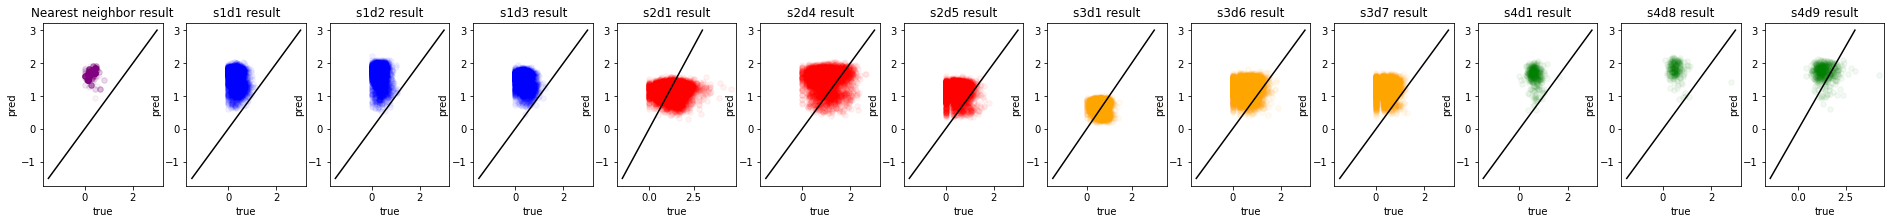

Epoch  100 near loss: 0.032399114 s1d1:  0.17718205 s1d2:  0.18256164 s1d3:  0.2133059 s2d1: 1.1067483 s2d4: 0.8201743 s2d5: 0.36158758 s3d1: 0.42081946 s3d6: 0.43031973 s3d7: 0.27489766 s4d1: 0.40162277 s4d8: 0.35893148 s4d9: 1.1859645 test loss: 0.8521335119618593
Epoch  200 near loss: 0.017257594 s1d1:  0.17692663 s1d2:  0.181511 s1d3:  0.21440166 s2d1: 1.1105589 s2d4: 0.8227343 s2d5: 0.36365306 s3d1: 0.42279023 s3d6: 0.43102184 s3d7: 0.27568978 s4d1: 0.40453723 s4d8: 0.36018777 s4d9: 1.1881711 test loss: 0.8541123894721194
Epoch  300 near loss: 0.009839524 s1d1:  0.17668448 s1d2:  0.18073043 s1d3:  0.21423714 s2d1: 1.1113964 s2d4: 0.82296175 s2d5: 0.36486638 s3d1: 0.42202824 s3d6: 0.4309369 s3d7: 0.2760215 s4d1: 0.40463424 s4d8: 0.36015683 s4d9: 1.1873791 test loss: 0.8536193406488193
Epoch  400 near loss: 0.008352915 s1d1:  0.17570868 s1d2:  0.17921418 s1d3:  0.21176326 s2d1: 1.1075686 s2d4: 0.8178495 s2d5: 0.36243063 s3d1: 0.41798997 s3d6: 0.42705885 s3d7: 0.27369493 s4d1: 0.4002

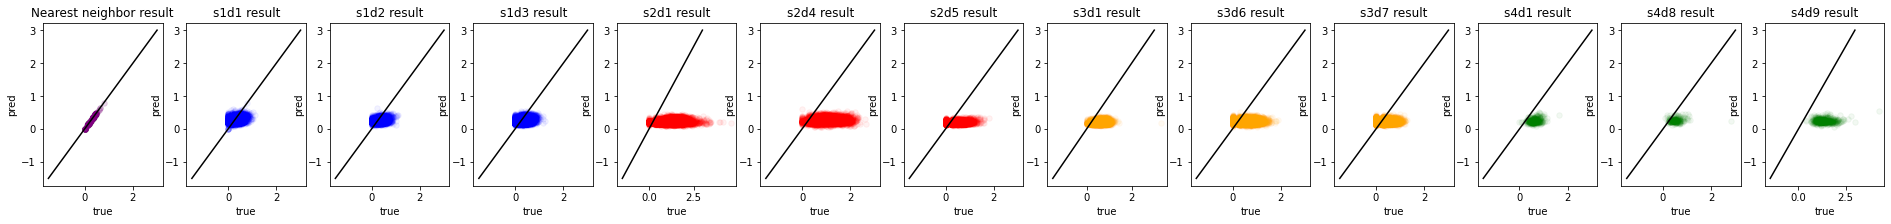

Epoch  1100 near loss: 0.0035527928 s1d1:  0.17627671 s1d2:  0.17940754 s1d3:  0.21232423 s2d1: 1.1058236 s2d4: 0.8198119 s2d5: 0.36178955 s3d1: 0.41161647 s3d6: 0.42615902 s3d7: 0.2734679 s4d1: 0.4029797 s4d8: 0.3594501 s4d9: 1.1836157 test loss: 0.850892900623064
Epoch  1200 near loss: 0.004238662 s1d1:  0.17631215 s1d2:  0.17944533 s1d3:  0.21236652 s2d1: 1.1053572 s2d4: 0.8199972 s2d5: 0.3612956 s3d1: 0.41102618 s3d6: 0.42569664 s3d7: 0.2730809 s4d1: 0.40374675 s4d8: 0.35969296 s4d9: 1.1841707 test loss: 0.8513898985954023
Epoch  1300 near loss: 0.0033124876 s1d1:  0.17613071 s1d2:  0.17900468 s1d3:  0.21186174 s2d1: 1.1043141 s2d4: 0.81905115 s2d5: 0.3603819 s3d1: 0.41011095 s3d6: 0.4247442 s3d7: 0.2724768 s4d1: 0.40183476 s4d8: 0.35760498 s4d9: 1.1819572 test loss: 0.8494918154708967
Epoch  1400 near loss: 0.002950198 s1d1:  0.17574304 s1d2:  0.17866926 s1d3:  0.21107462 s2d1: 1.1032817 s2d4: 0.81778115 s2d5: 0.35987586 s3d1: 0.40913406 s3d6: 0.42395046 s3d7: 0.27210683 s4d1: 0.4

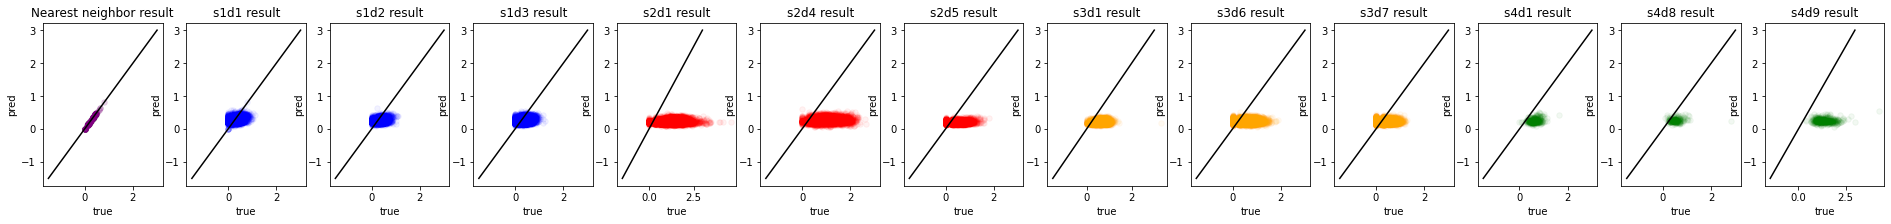

Epoch  2100 near loss: 0.003880473 s1d1:  0.17606017 s1d2:  0.1789618 s1d3:  0.21165873 s2d1: 1.1040218 s2d4: 0.82013947 s2d5: 0.3604096 s3d1: 0.40871295 s3d6: 0.42502075 s3d7: 0.27284914 s4d1: 0.4031616 s4d8: 0.35900095 s4d9: 1.1832721 test loss: 0.8506630462750422
Epoch  2200 near loss: 0.003000119 s1d1:  0.17576587 s1d2:  0.17864306 s1d3:  0.21084212 s2d1: 1.1026787 s2d4: 0.8187244 s2d5: 0.3597219 s3d1: 0.40755916 s3d6: 0.4240115 s3d7: 0.2722239 s4d1: 0.40193298 s4d8: 0.35809714 s4d9: 1.181695 test loss: 0.8493827737048286
Epoch  2300 near loss: 0.0029973479 s1d1:  0.17569104 s1d2:  0.17861055 s1d3:  0.21078327 s2d1: 1.1023655 s2d4: 0.81869715 s2d5: 0.35934505 s3d1: 0.40707016 s3d6: 0.42391598 s3d7: 0.2719932 s4d1: 0.40230185 s4d8: 0.35813975 s4d9: 1.182143 test loss: 0.8497308691828676
Epoch  2400 near loss: 0.002527423 s1d1:  0.17533061 s1d2:  0.17812183 s1d3:  0.2097845 s2d1: 1.1007546 s2d4: 0.8165754 s2d5: 0.35839495 s3d1: 0.40613014 s3d6: 0.42244717 s3d7: 0.2711968 s4d1: 0.3997

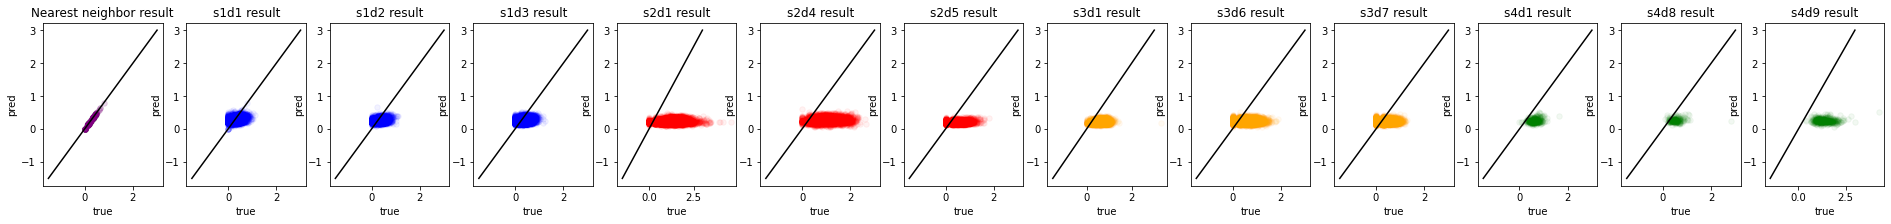

Epoch  3100 near loss: 0.0022565303 s1d1:  0.17531654 s1d2:  0.17809835 s1d3:  0.20969287 s2d1: 1.100306 s2d4: 0.8163219 s2d5: 0.35802412 s3d1: 0.4054102 s3d6: 0.42196205 s3d7: 0.27104506 s4d1: 0.39946625 s4d8: 0.3557437 s4d9: 1.1789151 test loss: 0.8470130280855269
Epoch  3200 near loss: 0.0021253296 s1d1:  0.17526709 s1d2:  0.17772743 s1d3:  0.20935577 s2d1: 1.0996122 s2d4: 0.81626517 s2d5: 0.35714802 s3d1: 0.40473154 s3d6: 0.4214025 s3d7: 0.27050766 s4d1: 0.3990025 s4d8: 0.35526067 s4d9: 1.1784146 test loss: 0.8465782036509417
Epoch  3300 near loss: 0.003504554 s1d1:  0.1753875 s1d2:  0.17800213 s1d3:  0.20963041 s2d1: 1.1005297 s2d4: 0.8169782 s2d5: 0.3580118 s3d1: 0.40510806 s3d6: 0.42228198 s3d7: 0.27111912 s4d1: 0.40028495 s4d8: 0.35662588 s4d9: 1.1798912 test loss: 0.8478423505404347
Epoch  3400 near loss: 0.0030628594 s1d1:  0.17507008 s1d2:  0.17742506 s1d3:  0.20886524 s2d1: 1.0995277 s2d4: 0.81573856 s2d5: 0.35716164 s3d1: 0.40452293 s3d6: 0.42139715 s3d7: 0.27045813 s4d1: 

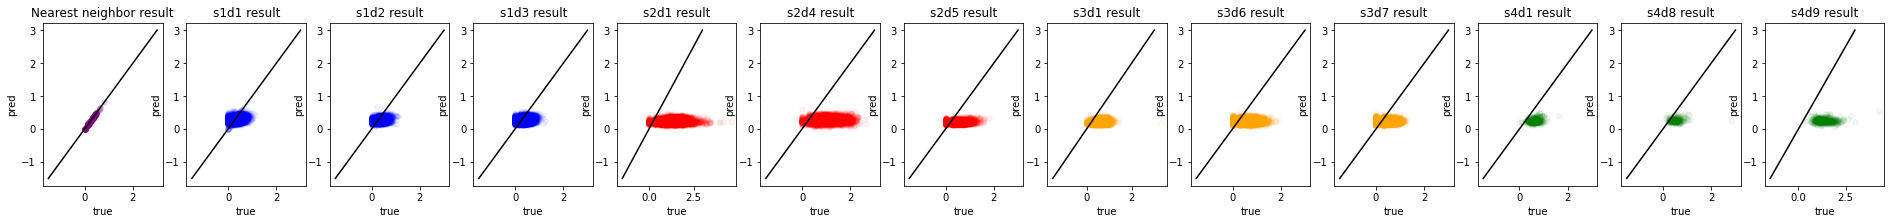

Epoch  4100 near loss: 0.004378997 s1d1:  0.17514887 s1d2:  0.17748614 s1d3:  0.20901546 s2d1: 1.0988523 s2d4: 0.8160538 s2d5: 0.35655445 s3d1: 0.4032983 s3d6: 0.42092267 s3d7: 0.27009183 s4d1: 0.39931712 s4d8: 0.35534102 s4d9: 1.1787287 test loss: 0.8468354088425157
Epoch  4200 near loss: 0.003876537 s1d1:  0.17513025 s1d2:  0.17741694 s1d3:  0.20865892 s2d1: 1.0987283 s2d4: 0.8158844 s2d5: 0.35650095 s3d1: 0.40322328 s3d6: 0.42083448 s3d7: 0.27008927 s4d1: 0.3987781 s4d8: 0.35498732 s4d9: 1.1780049 test loss: 0.8462573647830125
Epoch  4300 near loss: 0.0024405918 s1d1:  0.17501703 s1d2:  0.17748916 s1d3:  0.20880246 s2d1: 1.0988226 s2d4: 0.8161262 s2d5: 0.3567724 s3d1: 0.40345335 s3d6: 0.4211878 s3d7: 0.2701956 s4d1: 0.39919 s4d8: 0.35542747 s4d9: 1.1785706 test loss: 0.846721906240775
Epoch  4400 near loss: 0.0025976803 s1d1:  0.17481549 s1d2:  0.17739087 s1d3:  0.20812576 s2d1: 1.0973421 s2d4: 0.81435883 s2d5: 0.35603848 s3d1: 0.402448 s3d6: 0.42000702 s3d7: 0.2696702 s4d1: 0.39778

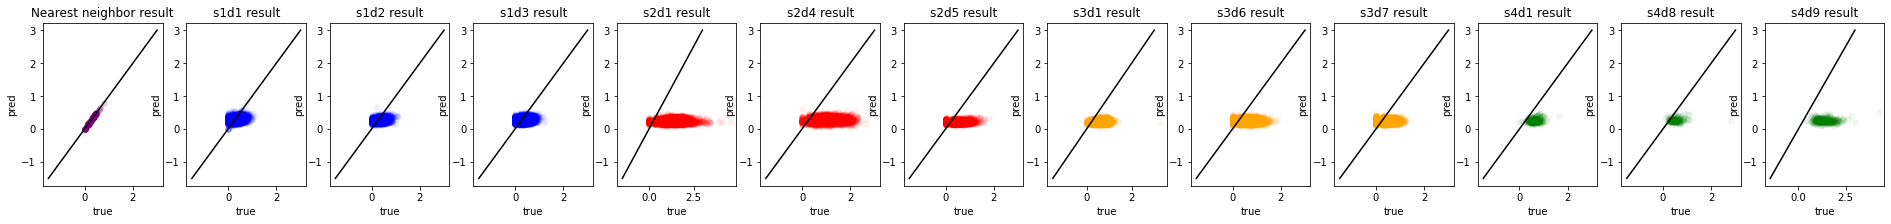

Epoch  5100 near loss: 0.002846574 s1d1:  0.17504245 s1d2:  0.1774603 s1d3:  0.20858578 s2d1: 1.0978445 s2d4: 0.8154762 s2d5: 0.355908 s3d1: 0.40229723 s3d6: 0.4205143 s3d7: 0.2696662 s4d1: 0.39875504 s4d8: 0.3549732 s4d9: 1.1781219 test loss: 0.8463273127222789
Epoch  5200 near loss: 0.001991011 s1d1:  0.17508157 s1d2:  0.17768808 s1d3:  0.2088738 s2d1: 1.098289 s2d4: 0.8157119 s2d5: 0.3565621 s3d1: 0.40271467 s3d6: 0.42092216 s3d7: 0.27002922 s4d1: 0.3993497 s4d8: 0.3551855 s4d9: 1.1786304 test loss: 0.8467641955905564
Epoch  5300 near loss: 0.003045251 s1d1:  0.17472783 s1d2:  0.17716628 s1d3:  0.2079222 s2d1: 1.096558 s2d4: 0.8138099 s2d5: 0.35527956 s3d1: 0.40151644 s3d6: 0.41951174 s3d7: 0.26913914 s4d1: 0.3973723 s4d8: 0.35362035 s4d9: 1.1763734 test loss: 0.8448751961895077
Epoch  5400 near loss: 0.00292598 s1d1:  0.1751529 s1d2:  0.17763226 s1d3:  0.20894781 s2d1: 1.0984046 s2d4: 0.8160403 s2d5: 0.35654303 s3d1: 0.40270057 s3d6: 0.4211133 s3d7: 0.2702026 s4d1: 0.3995409 s4d8: 

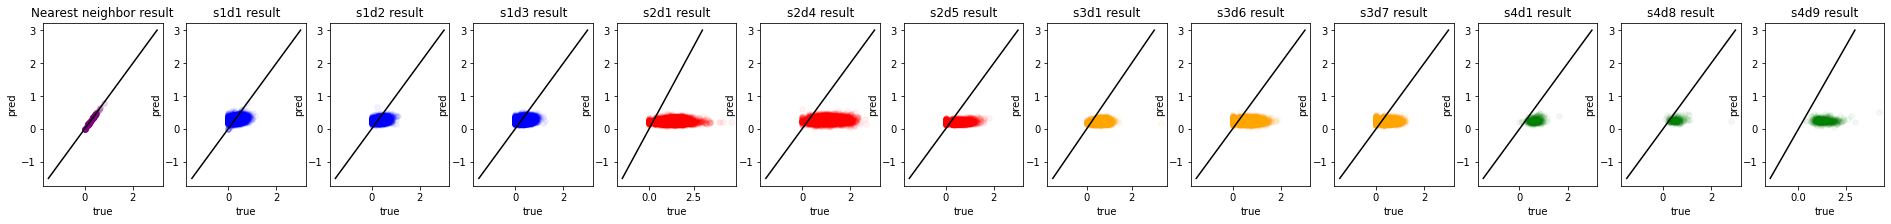

Epoch  6100 near loss: 0.0024328933 s1d1:  0.1747936 s1d2:  0.17713927 s1d3:  0.20804147 s2d1: 1.0967724 s2d4: 0.8144575 s2d5: 0.35552078 s3d1: 0.40188527 s3d6: 0.41972464 s3d7: 0.26939237 s4d1: 0.39803565 s4d8: 0.35426694 s4d9: 1.1772271 test loss: 0.8455811241902129
Epoch  6200 near loss: 0.002673057 s1d1:  0.17490722 s1d2:  0.17704362 s1d3:  0.2081159 s2d1: 1.0968361 s2d4: 0.8144895 s2d5: 0.35510296 s3d1: 0.40167752 s3d6: 0.41951656 s3d7: 0.2691364 s4d1: 0.39755768 s4d8: 0.3534701 s4d9: 1.1767491 test loss: 0.8451314434553262
Epoch  6300 near loss: 0.004095522 s1d1:  0.17468616 s1d2:  0.1769315 s1d3:  0.2078649 s2d1: 1.0964953 s2d4: 0.8141369 s2d5: 0.3550904 s3d1: 0.40150154 s3d6: 0.41953516 s3d7: 0.269108 s4d1: 0.39746797 s4d8: 0.3536934 s4d9: 1.1769123 test loss: 0.8452409855476282
Epoch  6400 near loss: 0.0019509619 s1d1:  0.17502369 s1d2:  0.177604 s1d3:  0.20859492 s2d1: 1.0973707 s2d4: 0.8149538 s2d5: 0.35578898 s3d1: 0.4021144 s3d6: 0.4200721 s3d7: 0.26962814 s4d1: 0.39831504

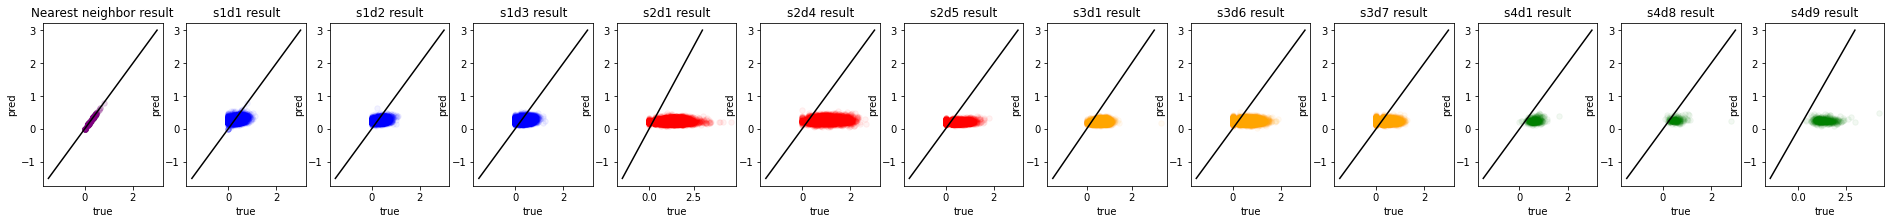

Epoch  7100 near loss: 0.0031101538 s1d1:  0.17476375 s1d2:  0.17695644 s1d3:  0.20780095 s2d1: 1.096319 s2d4: 0.8139469 s2d5: 0.35508296 s3d1: 0.40133336 s3d6: 0.41941026 s3d7: 0.2690797 s4d1: 0.39758837 s4d8: 0.35358712 s4d9: 1.1765438 test loss: 0.845015222037422
Epoch  7200 near loss: 0.0023979573 s1d1:  0.1750555 s1d2:  0.17754899 s1d3:  0.20872164 s2d1: 1.0975016 s2d4: 0.81548625 s2d5: 0.35601395 s3d1: 0.40237606 s3d6: 0.42051458 s3d7: 0.26974362 s4d1: 0.39910576 s4d8: 0.3547666 s4d9: 1.1782417 test loss: 0.8464411386767834
Epoch  7300 near loss: 0.0027741427 s1d1:  0.17461559 s1d2:  0.17695574 s1d3:  0.20769557 s2d1: 1.0957484 s2d4: 0.81304157 s2d5: 0.35471636 s3d1: 0.4013318 s3d6: 0.41881326 s3d7: 0.2687535 s4d1: 0.3966836 s4d8: 0.35283417 s4d9: 1.1756233 test loss: 0.8442195915505329
Epoch  7400 near loss: 0.0018972489 s1d1:  0.17485635 s1d2:  0.17714263 s1d3:  0.20831719 s2d1: 1.0970225 s2d4: 0.81453115 s2d5: 0.35534558 s3d1: 0.40200904 s3d6: 0.41987097 s3d7: 0.26921305 s4d1:

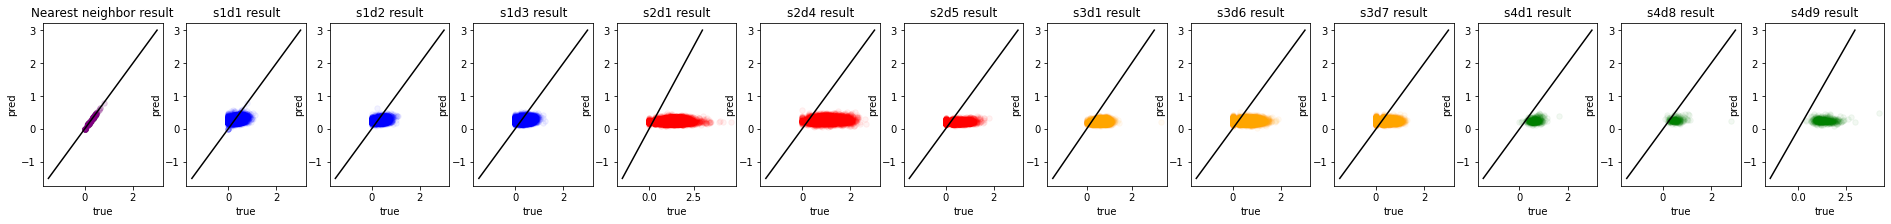

Epoch  8100 near loss: 0.0019602396 s1d1:  0.17474885 s1d2:  0.17696482 s1d3:  0.20781939 s2d1: 1.0961908 s2d4: 0.8138328 s2d5: 0.35484135 s3d1: 0.40131345 s3d6: 0.41915926 s3d7: 0.26886198 s4d1: 0.39748582 s4d8: 0.35297883 s4d9: 1.1764876 test loss: 0.8449104894804782
Epoch  8200 near loss: 0.0017292501 s1d1:  0.1748978 s1d2:  0.17699541 s1d3:  0.20794243 s2d1: 1.0965462 s2d4: 0.8143886 s2d5: 0.35496822 s3d1: 0.40161696 s3d6: 0.41950288 s3d7: 0.26902807 s4d1: 0.3978833 s4d8: 0.35344228 s4d9: 1.1766231 test loss: 0.8450997082432482
Epoch  8300 near loss: 0.0011330858 s1d1:  0.17487095 s1d2:  0.17718418 s1d3:  0.20816791 s2d1: 1.0967684 s2d4: 0.81455475 s2d5: 0.35524824 s3d1: 0.40156117 s3d6: 0.41974068 s3d7: 0.2691882 s4d1: 0.39843452 s4d8: 0.3536782 s4d9: 1.1771989 test loss: 0.8455747969087295
Epoch  8400 near loss: 0.0023828424 s1d1:  0.17496815 s1d2:  0.17716774 s1d3:  0.20817089 s2d1: 1.0967937 s2d4: 0.81499016 s2d5: 0.35518616 s3d1: 0.40176132 s3d6: 0.41980925 s3d7: 0.2691963 s4d

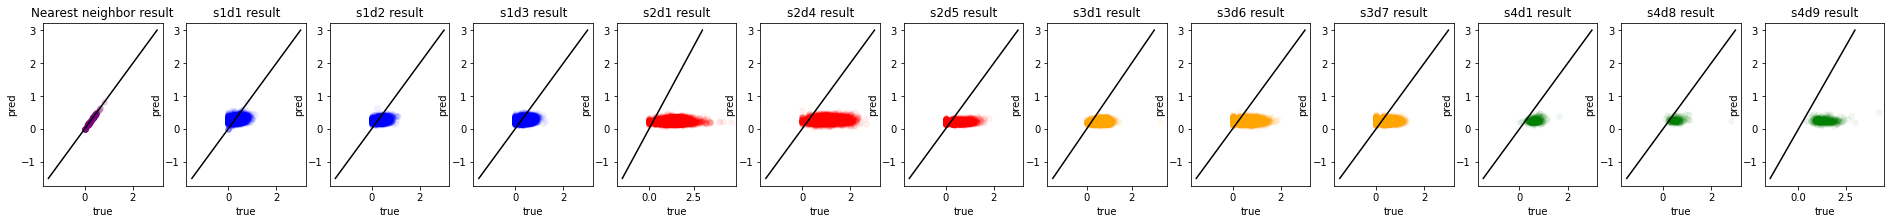

Epoch  9100 near loss: 0.0041190176 s1d1:  0.17497721 s1d2:  0.1771889 s1d3:  0.2083812 s2d1: 1.0971183 s2d4: 0.81531805 s2d5: 0.35552132 s3d1: 0.40179974 s3d6: 0.42019603 s3d7: 0.26940152 s4d1: 0.39945725 s4d8: 0.35464725 s4d9: 1.1786289 test loss: 0.8467335339223654
Epoch  9200 near loss: 0.0025051439 s1d1:  0.17520279 s1d2:  0.17744672 s1d3:  0.20879252 s2d1: 1.0980492 s2d4: 0.8163406 s2d5: 0.35590425 s3d1: 0.40249926 s3d6: 0.42067397 s3d7: 0.26963958 s4d1: 0.39974672 s4d8: 0.3549084 s4d9: 1.1787369 test loss: 0.8468708167113554
Epoch  9300 near loss: 0.0031788927 s1d1:  0.1748844 s1d2:  0.17685096 s1d3:  0.20775479 s2d1: 1.0964208 s2d4: 0.8147456 s2d5: 0.35465592 s3d1: 0.40133405 s3d6: 0.41935337 s3d7: 0.26885065 s4d1: 0.39779162 s4d8: 0.35332158 s4d9: 1.1767712 test loss: 0.8451694702848308
Epoch  9400 near loss: 0.0043912577 s1d1:  0.17399292 s1d2:  0.17587058 s1d3:  0.20584415 s2d1: 1.0934429 s2d4: 0.8107212 s2d5: 0.35313687 s3d1: 0.39962745 s3d6: 0.41704795 s3d7: 0.2676376 s4d1

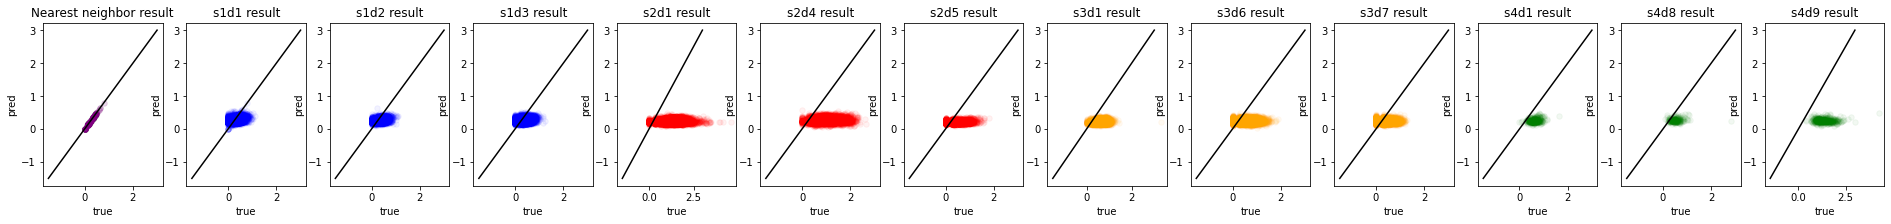

Epoch  10100 near loss: 0.0037559879 s1d1:  0.17480057 s1d2:  0.17672299 s1d3:  0.20773642 s2d1: 1.0962281 s2d4: 0.8143687 s2d5: 0.3545625 s3d1: 0.4006114 s3d6: 0.41901374 s3d7: 0.26862618 s4d1: 0.3979707 s4d8: 0.35355052 s4d9: 1.1770614 test loss: 0.8454029314812679
Epoch  10200 near loss: 0.0031921724 s1d1:  0.17523259 s1d2:  0.17713246 s1d3:  0.20857063 s2d1: 1.0970949 s2d4: 0.81585044 s2d5: 0.3549152 s3d1: 0.40120408 s3d6: 0.4196263 s3d7: 0.26898262 s4d1: 0.39900723 s4d8: 0.35415685 s4d9: 1.1780735 test loss: 0.84626527992742
Epoch  10300 near loss: 0.0035527323 s1d1:  0.17469206 s1d2:  0.17636383 s1d3:  0.20730408 s2d1: 1.0958881 s2d4: 0.81427264 s2d5: 0.3542728 s3d1: 0.4004845 s3d6: 0.4187971 s3d7: 0.26856947 s4d1: 0.39729065 s4d8: 0.3528279 s4d9: 1.1763178 test loss: 0.8447582934379029
Epoch  10400 near loss: 0.003367846 s1d1:  0.17479803 s1d2:  0.17697074 s1d3:  0.20800793 s2d1: 1.0966997 s2d4: 0.8147982 s2d5: 0.35518682 s3d1: 0.40118444 s3d6: 0.41964108 s3d7: 0.26909354 s4d1: 

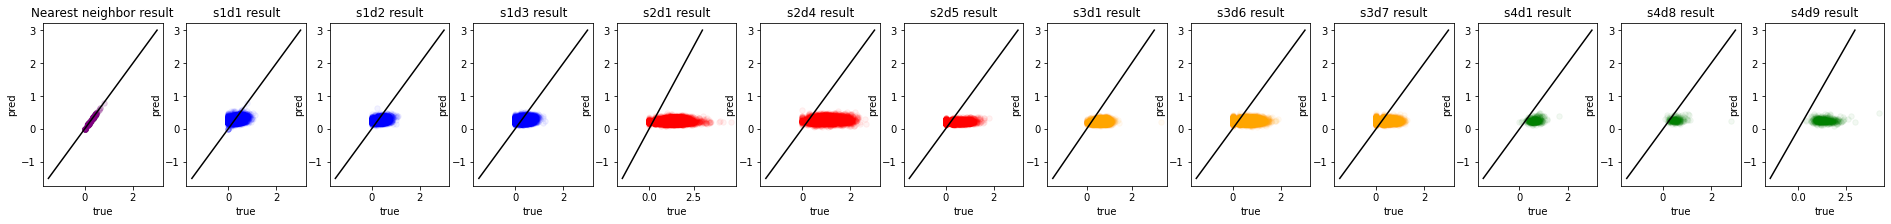

Epoch  11100 near loss: 0.001967556 s1d1:  0.17462322 s1d2:  0.17665648 s1d3:  0.20749773 s2d1: 1.0952299 s2d4: 0.8136381 s2d5: 0.35402074 s3d1: 0.39987195 s3d6: 0.418341 s3d7: 0.26824546 s4d1: 0.3974128 s4d8: 0.35304058 s4d9: 1.1764007 test loss: 0.8448488240312751
Epoch  11200 near loss: 0.0030357796 s1d1:  0.17493156 s1d2:  0.17683542 s1d3:  0.20794635 s2d1: 1.0961151 s2d4: 0.8149835 s2d5: 0.3544433 s3d1: 0.40007737 s3d6: 0.41904485 s3d7: 0.26860374 s4d1: 0.3985605 s4d8: 0.35376066 s4d9: 1.1776397 test loss: 0.8458834549170001
Epoch  11300 near loss: 0.002474533 s1d1:  0.17454702 s1d2:  0.17636167 s1d3:  0.20695592 s2d1: 1.0942327 s2d4: 0.8128258 s2d5: 0.3532955 s3d1: 0.3990014 s3d6: 0.41744968 s3d7: 0.26782352 s4d1: 0.3961006 s4d8: 0.35179058 s4d9: 1.1750066 test loss: 0.8436437805082078
Epoch  11400 near loss: 0.0015936791 s1d1:  0.17462602 s1d2:  0.17663021 s1d3:  0.20745432 s2d1: 1.0951793 s2d4: 0.8138354 s2d5: 0.35388836 s3d1: 0.39938784 s3d6: 0.4183576 s3d7: 0.2682812 s4d1: 0.

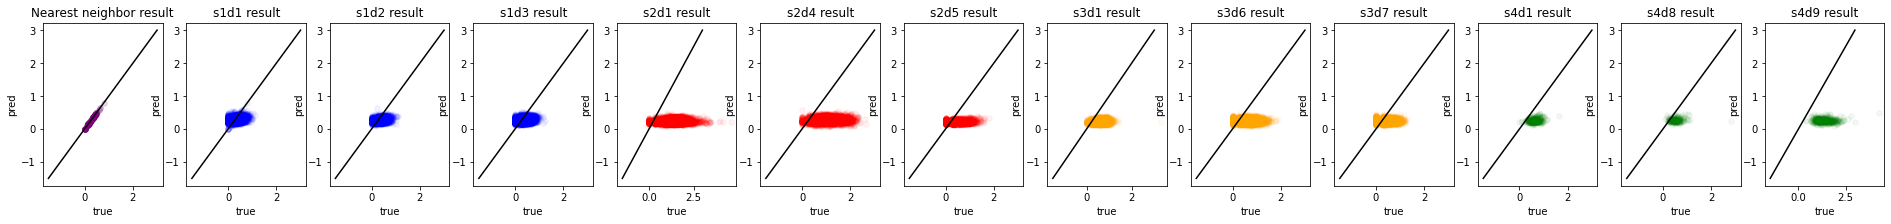

Epoch  12100 near loss: 0.0023540386 s1d1:  0.17471518 s1d2:  0.1767252 s1d3:  0.20781337 s2d1: 1.0954754 s2d4: 0.81477356 s2d5: 0.35419226 s3d1: 0.39956617 s3d6: 0.41876307 s3d7: 0.26853165 s4d1: 0.3983025 s4d8: 0.35388848 s4d9: 1.177429 test loss: 0.8457192448848321
Epoch  12200 near loss: 0.0038196372 s1d1:  0.17502101 s1d2:  0.17697716 s1d3:  0.20828359 s2d1: 1.0960621 s2d4: 0.8153156 s2d5: 0.3542678 s3d1: 0.39987132 s3d6: 0.418884 s3d7: 0.26851267 s4d1: 0.39887577 s4d8: 0.35420758 s4d9: 1.177887 test loss: 0.8461297690103151
Epoch  12300 near loss: 0.002762368 s1d1:  0.17473404 s1d2:  0.17667568 s1d3:  0.20775591 s2d1: 1.0948764 s2d4: 0.81401306 s2d5: 0.35359466 s3d1: 0.39907426 s3d6: 0.41802058 s3d7: 0.26794463 s4d1: 0.39769423 s4d8: 0.35298565 s4d9: 1.1767577 test loss: 0.8451164939027659
Epoch  12400 near loss: 0.0024988172 s1d1:  0.17500074 s1d2:  0.17707159 s1d3:  0.20823552 s2d1: 1.0959817 s2d4: 0.815324 s2d5: 0.35440856 s3d1: 0.40007597 s3d6: 0.41893142 s3d7: 0.26858166 s4d

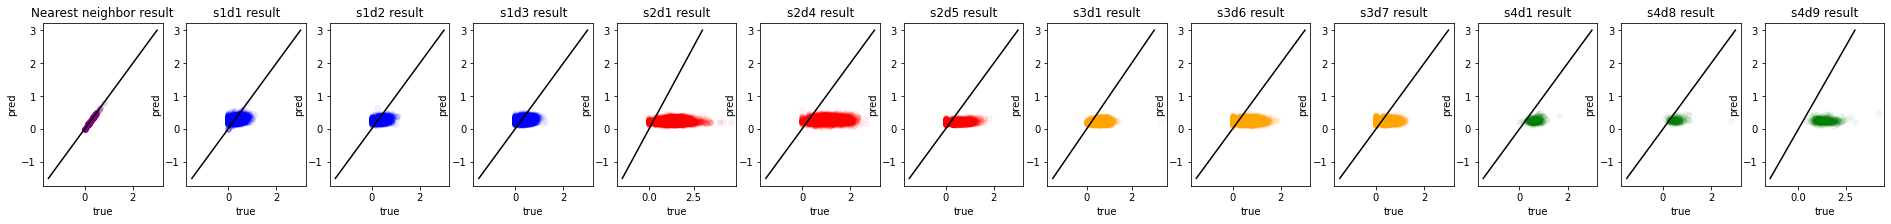

Epoch  13100 near loss: 0.002508686 s1d1:  0.17481981 s1d2:  0.17661731 s1d3:  0.2076865 s2d1: 1.0948423 s2d4: 0.81448764 s2d5: 0.3533868 s3d1: 0.39921504 s3d6: 0.4179559 s3d7: 0.26794028 s4d1: 0.3975834 s4d8: 0.3526751 s4d9: 1.1762776 test loss: 0.8447654048522857
Epoch  13200 near loss: 0.0026884868 s1d1:  0.17450552 s1d2:  0.17636032 s1d3:  0.20712376 s2d1: 1.0942833 s2d4: 0.81300354 s2d5: 0.35315755 s3d1: 0.3989008 s3d6: 0.41747263 s3d7: 0.2676862 s4d1: 0.39628384 s4d8: 0.3520651 s4d9: 1.1752815 test loss: 0.843871925498567
Epoch  13300 near loss: 0.0019040698 s1d1:  0.17476578 s1d2:  0.17659272 s1d3:  0.207747 s2d1: 1.0952218 s2d4: 0.8144652 s2d5: 0.35357636 s3d1: 0.3994117 s3d6: 0.4181512 s3d7: 0.2680234 s4d1: 0.39785832 s4d8: 0.35317722 s4d9: 1.1769105 test loss: 0.8452565149340642
Epoch  13400 near loss: 0.0016370475 s1d1:  0.1746328 s1d2:  0.17655736 s1d3:  0.20752978 s2d1: 1.0948247 s2d4: 0.81406647 s2d5: 0.3535779 s3d1: 0.39920038 s3d6: 0.41807044 s3d7: 0.26798698 s4d1: 0.39

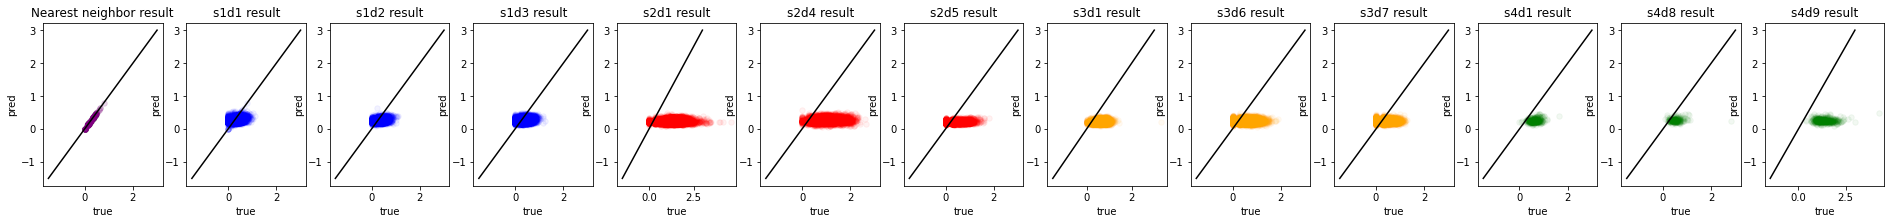

Epoch  14100 near loss: 0.0023135082 s1d1:  0.17483512 s1d2:  0.17658018 s1d3:  0.2075899 s2d1: 1.0948879 s2d4: 0.81411314 s2d5: 0.35318205 s3d1: 0.3990298 s3d6: 0.41778564 s3d7: 0.2677204 s4d1: 0.3978109 s4d8: 0.3529468 s4d9: 1.176383 test loss: 0.8448920190653376
Epoch  14200 near loss: 0.0054011014 s1d1:  0.17512077 s1d2:  0.17688468 s1d3:  0.20803645 s2d1: 1.0953103 s2d4: 0.8154207 s2d5: 0.35365802 s3d1: 0.39914602 s3d6: 0.4183653 s3d7: 0.26803574 s4d1: 0.39883822 s4d8: 0.35403213 s4d9: 1.1775905 test loss: 0.8459192176209472
Epoch  14300 near loss: 0.0029109938 s1d1:  0.1749692 s1d2:  0.17684968 s1d3:  0.20810413 s2d1: 1.0954553 s2d4: 0.81499124 s2d5: 0.35376948 s3d1: 0.39937428 s3d6: 0.41846406 s3d7: 0.26815075 s4d1: 0.39868402 s4d8: 0.3538421 s4d9: 1.1775463 test loss: 0.8458502147407921
Epoch  14400 near loss: 0.0017078825 s1d1:  0.17454556 s1d2:  0.17642266 s1d3:  0.20714359 s2d1: 1.0938098 s2d4: 0.813224 s2d5: 0.35299852 s3d1: 0.3983925 s3d6: 0.41729933 s3d7: 0.26764533 s4d1:

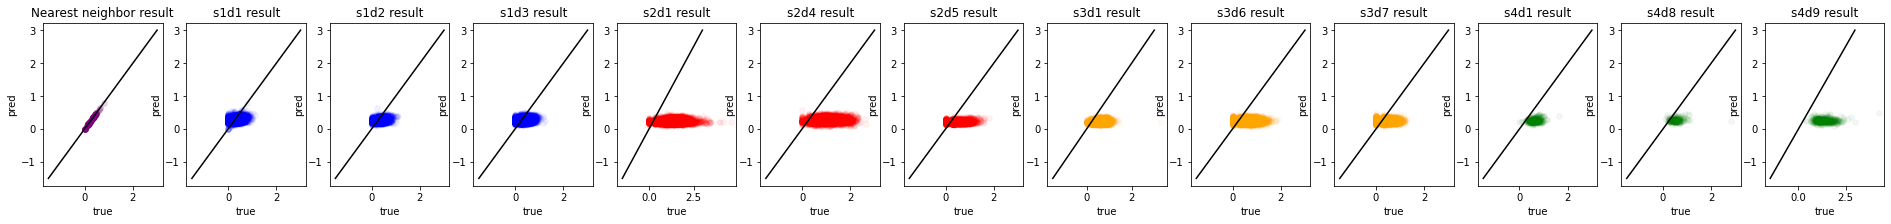

Epoch  15100 near loss: 0.0020512212 s1d1:  0.17435837 s1d2:  0.1762802 s1d3:  0.20687048 s2d1: 1.0930251 s2d4: 0.8125538 s2d5: 0.35252893 s3d1: 0.3976705 s3d6: 0.41682315 s3d7: 0.26729202 s4d1: 0.39608243 s4d8: 0.35153645 s4d9: 1.174822 test loss: 0.8435009472495556
Epoch  15200 near loss: 0.0015581754 s1d1:  0.17469731 s1d2:  0.17659275 s1d3:  0.20762166 s2d1: 1.0943571 s2d4: 0.81384736 s2d5: 0.35315594 s3d1: 0.39859065 s3d6: 0.417665 s3d7: 0.26767 s4d1: 0.39719608 s4d8: 0.35214803 s4d9: 1.175881 test loss: 0.8444055057864494
Epoch  15300 near loss: 0.0022057968 s1d1:  0.17472398 s1d2:  0.17659336 s1d3:  0.20775096 s2d1: 1.0948594 s2d4: 0.8143987 s2d5: 0.35346246 s3d1: 0.39888057 s3d6: 0.41804215 s3d7: 0.26785704 s4d1: 0.39803863 s4d8: 0.3529118 s4d9: 1.1767414 test loss: 0.8451538056316914
Epoch  15400 near loss: 0.0013719331 s1d1:  0.1747698 s1d2:  0.17676342 s1d3:  0.2078642 s2d1: 1.0944687 s2d4: 0.8141039 s2d5: 0.35334134 s3d1: 0.39882737 s3d6: 0.4177945 s3d7: 0.26781547 s4d1: 0.

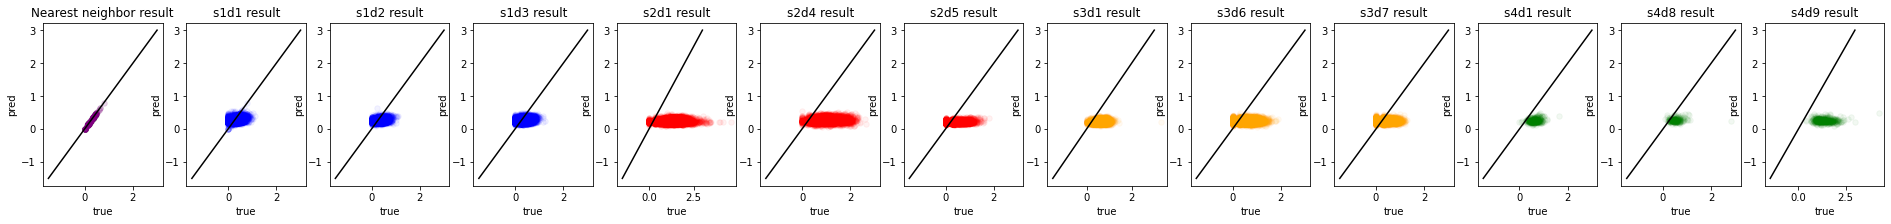

Epoch  16100 near loss: 0.0015564113 s1d1:  0.17441255 s1d2:  0.17636469 s1d3:  0.2070776 s2d1: 1.0935746 s2d4: 0.81333995 s2d5: 0.35276514 s3d1: 0.39804393 s3d6: 0.41706568 s3d7: 0.2674511 s4d1: 0.3966175 s4d8: 0.35161525 s4d9: 1.1752117 test loss: 0.8438408160166949
Epoch  16200 near loss: 0.0016047646 s1d1:  0.17466472 s1d2:  0.17652643 s1d3:  0.20750625 s2d1: 1.0940042 s2d4: 0.8137889 s2d5: 0.3527599 s3d1: 0.39823306 s3d6: 0.41733238 s3d7: 0.26741588 s4d1: 0.39722568 s4d8: 0.35204992 s4d9: 1.1758121 test loss: 0.8443576522724441
Epoch  16300 near loss: 0.0012919359 s1d1:  0.17461173 s1d2:  0.17651094 s1d3:  0.20752184 s2d1: 1.0939666 s2d4: 0.81356996 s2d5: 0.35279116 s3d1: 0.39825532 s3d6: 0.41727126 s3d7: 0.2674677 s4d1: 0.3969474 s4d8: 0.35197034 s4d9: 1.1754324 test loss: 0.8440643718344586
Epoch  16400 near loss: 0.0031583733 s1d1:  0.17499515 s1d2:  0.17691855 s1d3:  0.20836914 s2d1: 1.0953385 s2d4: 0.815446 s2d5: 0.3536432 s3d1: 0.3989471 s3d6: 0.41834697 s3d7: 0.267965 s4d1:

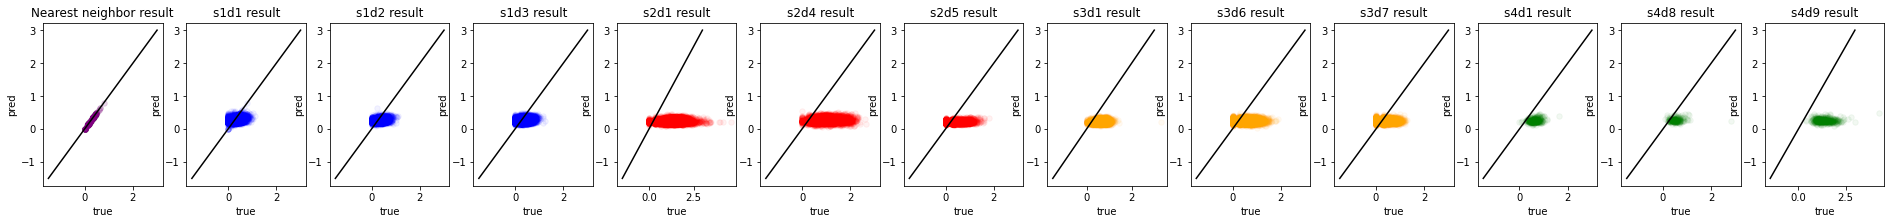

Epoch  17100 near loss: 0.0023320194 s1d1:  0.17457172 s1d2:  0.17631279 s1d3:  0.20731142 s2d1: 1.0935028 s2d4: 0.81307536 s2d5: 0.35240155 s3d1: 0.39780578 s3d6: 0.41683075 s3d7: 0.26722813 s4d1: 0.39645138 s4d8: 0.35138735 s4d9: 1.1747692 test loss: 0.8435122144136749
Epoch  17200 near loss: 0.002490351 s1d1:  0.17441277 s1d2:  0.1761054 s1d3:  0.20667575 s2d1: 1.0925297 s2d4: 0.8121816 s2d5: 0.35166442 s3d1: 0.39713824 s3d6: 0.41603875 s3d7: 0.2667317 s4d1: 0.39532152 s4d8: 0.35052472 s4d9: 1.1736606 test loss: 0.8425519660457883
Epoch  17300 near loss: 0.003742007 s1d1:  0.17434987 s1d2:  0.1763173 s1d3:  0.20706198 s2d1: 1.0933243 s2d4: 0.81321716 s2d5: 0.35266384 s3d1: 0.39786658 s3d6: 0.41706076 s3d7: 0.26743537 s4d1: 0.39707115 s4d8: 0.35217303 s4d9: 1.17566 test loss: 0.8442467948921146
Epoch  17400 near loss: 0.0022901385 s1d1:  0.17451243 s1d2:  0.1762949 s1d3:  0.20711258 s2d1: 1.0932461 s2d4: 0.8128084 s2d5: 0.35214 s3d1: 0.3978531 s3d6: 0.4165005 s3d7: 0.2670647 s4d1: 0.

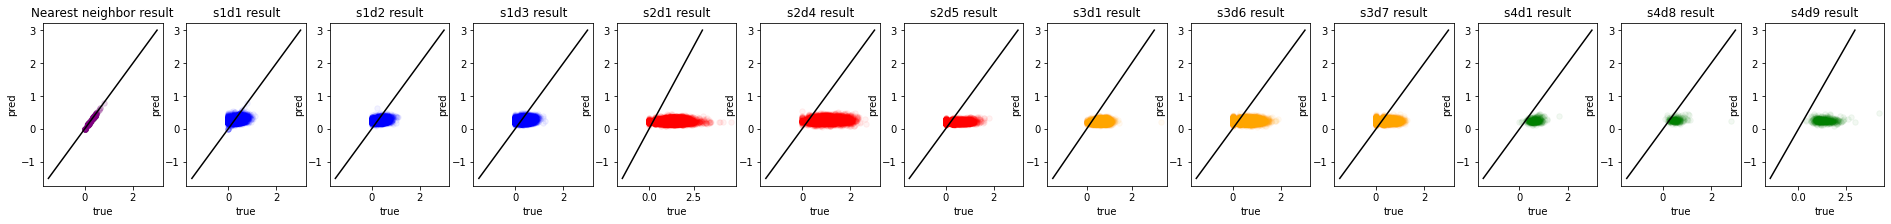

Epoch  18100 near loss: 0.0027230966 s1d1:  0.1745331 s1d2:  0.17627382 s1d3:  0.20690864 s2d1: 1.0927892 s2d4: 0.8126898 s2d5: 0.35196108 s3d1: 0.39757803 s3d6: 0.41629067 s3d7: 0.26693425 s4d1: 0.39577645 s4d8: 0.35087758 s4d9: 1.1738861 test loss: 0.8427978048592267
Epoch  18200 near loss: 0.002308071 s1d1:  0.17482981 s1d2:  0.17674598 s1d3:  0.20795114 s2d1: 1.0946913 s2d4: 0.8150003 s2d5: 0.35321775 s3d1: 0.39867726 s3d6: 0.41794273 s3d7: 0.26781744 s4d1: 0.39839616 s4d8: 0.3531368 s4d9: 1.1771795 test loss: 0.8455094964329409
Epoch  18300 near loss: 0.0026397288 s1d1:  0.17470202 s1d2:  0.17656633 s1d3:  0.2076651 s2d1: 1.0945565 s2d4: 0.81468517 s2d5: 0.35313508 s3d1: 0.39862525 s3d6: 0.41787425 s3d7: 0.26777592 s4d1: 0.39818716 s4d8: 0.35285026 s4d9: 1.1768248 test loss: 0.8452252015614657
Epoch  18400 near loss: 0.0015350694 s1d1:  0.17477696 s1d2:  0.17668727 s1d3:  0.2079112 s2d1: 1.0944549 s2d4: 0.81452966 s2d5: 0.3530601 s3d1: 0.3985196 s3d6: 0.41766825 s3d7: 0.2676208 s4

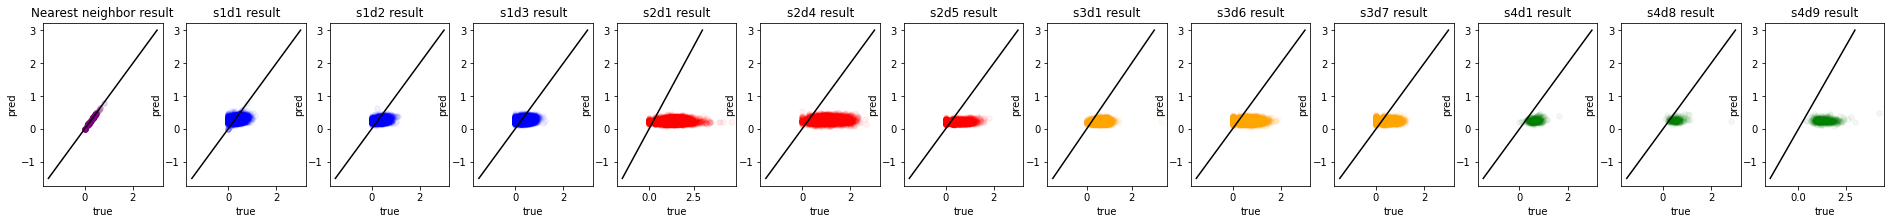

Epoch  19100 near loss: 0.003225188 s1d1:  0.17411642 s1d2:  0.17584893 s1d3:  0.20620763 s2d1: 1.0919428 s2d4: 0.8113569 s2d5: 0.35153005 s3d1: 0.39685518 s3d6: 0.4156338 s3d7: 0.26656535 s4d1: 0.39469242 s4d8: 0.3498238 s4d9: 1.1729693 test loss: 0.8419510758905889
Epoch  19200 near loss: 0.0019634084 s1d1:  0.17485377 s1d2:  0.17668821 s1d3:  0.20786187 s2d1: 1.0940804 s2d4: 0.8142001 s2d5: 0.35263592 s3d1: 0.39827135 s3d6: 0.41719803 s3d7: 0.2673332 s4d1: 0.39732715 s4d8: 0.35191956 s4d9: 1.1756352 test loss: 0.8442492955263202
Epoch  19300 near loss: 0.0018416643 s1d1:  0.17444392 s1d2:  0.17627788 s1d3:  0.20705049 s2d1: 1.0930631 s2d4: 0.81314313 s2d5: 0.35215926 s3d1: 0.39767605 s3d6: 0.41661975 s3d7: 0.26704758 s4d1: 0.3965198 s4d8: 0.3511787 s4d9: 1.1746706 test loss: 0.8434419497711406
Epoch  19400 near loss: 0.002637901 s1d1:  0.17446539 s1d2:  0.17634572 s1d3:  0.20728873 s2d1: 1.0937583 s2d4: 0.8136905 s2d5: 0.35253978 s3d1: 0.39803514 s3d6: 0.41723105 s3d7: 0.26728866 s4

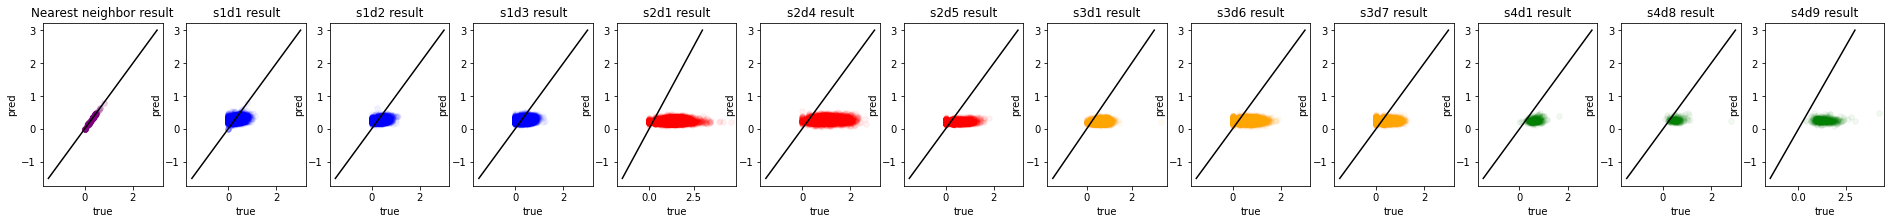

Epoch  20100 near loss: 0.0018589407 s1d1:  0.1743746 s1d2:  0.17612912 s1d3:  0.20695011 s2d1: 1.0932693 s2d4: 0.8131297 s2d5: 0.3522239 s3d1: 0.39785686 s3d6: 0.41662082 s3d7: 0.2670033 s4d1: 0.39629838 s4d8: 0.35101363 s4d9: 1.1745995 test loss: 0.843347548034804
Epoch  20200 near loss: 0.0013172885 s1d1:  0.17427918 s1d2:  0.17609157 s1d3:  0.20671564 s2d1: 1.092864 s2d4: 0.8127497 s2d5: 0.35191816 s3d1: 0.3976457 s3d6: 0.41638002 s3d7: 0.26690534 s4d1: 0.39607525 s4d8: 0.35043523 s4d9: 1.1741201 test loss: 0.8429561900775534
Epoch  20300 near loss: 0.0025655671 s1d1:  0.17438915 s1d2:  0.17623255 s1d3:  0.20707911 s2d1: 1.0934838 s2d4: 0.813593 s2d5: 0.35251275 s3d1: 0.39803368 s3d6: 0.417024 s3d7: 0.2673086 s4d1: 0.3970826 s4d8: 0.35156447 s4d9: 1.1755186 test loss: 0.8441056980761005
Epoch  20400 near loss: 0.0027370737 s1d1:  0.17463289 s1d2:  0.17642573 s1d3:  0.20747581 s2d1: 1.0936524 s2d4: 0.8141209 s2d5: 0.35238907 s3d1: 0.39810795 s3d6: 0.41702637 s3d7: 0.26720437 s4d1: 0

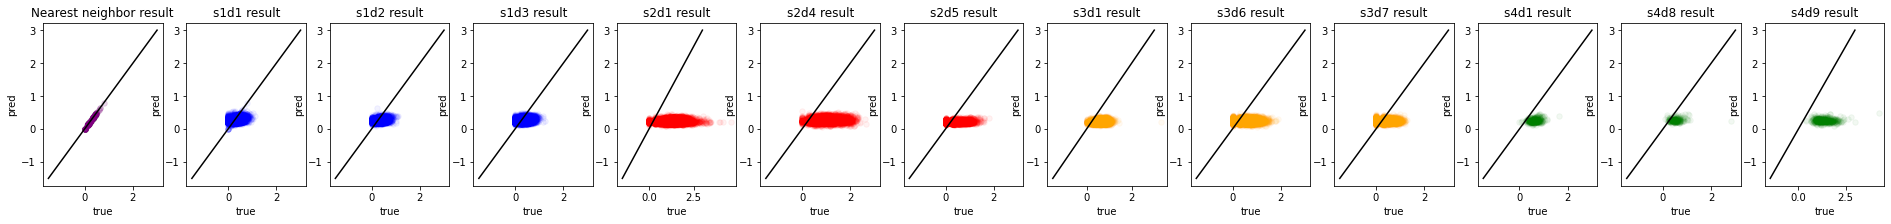

Epoch  21100 near loss: 0.0018350116 s1d1:  0.17432551 s1d2:  0.17605397 s1d3:  0.20669976 s2d1: 1.0928899 s2d4: 0.8128349 s2d5: 0.35181862 s3d1: 0.39769772 s3d6: 0.4163754 s3d7: 0.26680535 s4d1: 0.3959201 s4d8: 0.3505998 s4d9: 1.1742436 test loss: 0.8430249731036122
Epoch  21200 near loss: 0.0017525281 s1d1:  0.17443904 s1d2:  0.17609558 s1d3:  0.20699206 s2d1: 1.0934354 s2d4: 0.8134949 s2d5: 0.35215 s3d1: 0.3980084 s3d6: 0.4167302 s3d7: 0.26701564 s4d1: 0.39641425 s4d8: 0.3510511 s4d9: 1.174864 test loss: 0.8435380573360164


KeyboardInterrupt: 

In [44]:
num_epochs = 50000
learning_rate = 0.01
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
fit(num_epochs, model, loss_fn, input_near, output_near)